In [127]:
from bs4 import BeautifulSoup
import requests
import re
import math
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm
%matplotlib inline

In [2]:
def get_url(page, year, rating):
    head = 'http://www.boxofficemojo.com/yearly/chart/mpaarating.htm?'
    page = 'page='+str(page)+'&'
    year = 'yr='+str(year)+'&'
    rating = 'rating='+rating+'&'
    end = 'view=releasedate&p=.htm'
    url = head+page+year+rating+end
    return url

In [3]:
def get_soup(url):
    response = requests.get(url) 
    soup = None
    if response.status_code == 200:
        page = response.text
        soup = BeautifulSoup(page, 'html5lib')
    else:
        print 'Unresponsive. Trying Again...'
        time.sleep(0.5)
        return get_soup(url)
    return soup


In [4]:
def get_pages(soup):
    for b in soup.find_all('b'):
        bolded = b.text
        if 'Summary of' in bolded:
            numbers = ''.join(re.findall(re.compile('\d'),bolded))
            return int(math.ceil(float(numbers)/100)) 
    return 0
        

In [5]:
def get_header(th):
    headers=[]
    for item in th:
        if item:
            headers.append(item.split('(')[0])
    headers[0] = 'Year'
    headers[4] = 'TotalGross'
    headers[5] = 'TG'+headers[5] 
    headers[7] = 'O'+headers[7] 
    if len(headers)==9:
        if headers[-1] != 'Close':
            headers.append(u'Close')
            return (headers, True)
    return (headers, False)

In [6]:
def make_df(soup, year):
    table = soup.find("table", attrs={"cellpadding":"5"})
    if table is None:
        return
    headers, addclose = get_header([a.text for a in table.tr.find_all('a')])
    df = pd.DataFrame()
    for tr in table('tr'): 
        if tr.get('bgcolor')=='#ffffff' or tr.get('bgcolor')=='#f4f4ff':
            if tr.text[0].isdigit():
                df = df.append(make_vector(tr, addclose), ignore_index=True)
    df.columns=headers
    df['Year'] = [year] * len(df)
#     df.drop('Rank', axis=1, inplace=True)
    return df

In [7]:
def clean_int(unistring):
    if unistring != u'N/A':
        return int(unistring.strip('$').replace(',',''))
    return unistring

In [8]:
def make_vector(tr, addclose):
    items = []
    for item in tr:
        items.append(item.text)
    if addclose == True:
        items.append(u'-')
    vals4to7 = [clean_int(items[i]) for i in range(4,8,1)]
    items = items[:4]+vals4to7+items[8:]

    return pd.Series(items)

    

In [9]:
# Make a dataframe for a certain year or rating for all pages
def category(year, rating):
    firsturl = get_url(1, year, rating)
    soup = get_soup(firsturl)
    pages = get_pages(soup)
    df = make_df(soup, year)
    for page in range(2, pages+1, 1):
        url = get_url(page, year, rating)
        soup = get_soup(url)
        df = pd.concat([df,make_df(soup, year)], ignore_index=True)
    return df

In [10]:
## By Year
## Given year, make a dataframe for each year and rating, 
## initializing with G ratings

def by_year(year):
    startrating = 'G'
    df = category(year,startrating)
    if df is None:
        df = pd.DataFrame()
    ratings = ['PG','PG-13','R','NC-17','Unrated']
    for rating in ratings:
        df = pd.concat([df, category(year, rating)], ignore_index=True)
    return df

In [11]:
## By Rating
## Given rating and range of years, 
## Make a dataframe for each year and rating,
## initializing with the first year

def by_rating(rating, startyear, endyear):
    df = category(startyear, rating)
    if df is None:
        df = pd.DataFrame()
    years = range(startyear+1, endyear+1, 1)
    for year in years:
        df = pd.concat([df, category(year, rating)], ignore_index=True)
    return df

In [13]:
## This function takes an array of ratings and returns an array of floats

def to_float(array):
    arr = np.empty(len(array))
    
    ratings = ['G','PG','PG-13','R','NC-17','Unrated']
    values = np.arange(float(6))    
    for rt in range(len(array)):
        rating = array[rt]
        index = ratings.index(rating) 
        arr[rt] = values[index]
        
    return arr

In [76]:
# Plot freq dist. of ratings for a year
def plot_hist_rats(data, year):
    rating_float = to_float(data['MPAARating'].values)
    labels = ['G','PG','PG-13','R','NC-17','Unrated']
    plt.hist(rating_float, bins=50)

    plt.xlabel('MPAA Rating')
    plt.ylabel('Count')
    plt.title('Movies made in '+str(year))
    plt.xticks([0,1,2,3,4,5], labels)

    plt.show()

In [74]:
# Plot ratings versus DTG for a year
def plot_2vars_rats(data, year):
    rating_float = to_float(data['MPAARating'].values)
    labels = ['G','PG','PG-13','R','NC-17','Unrated']
    sns.set_style('whitegrid')

    plt.scatter(rating_float, data['TotalGross'].values)

    plt.xlabel('MPAA Rating')
    plt.ylabel('Domestic Total Gross in millions')
    plt.title(str(year)+' movie gross by rating')
    plt.xticks([0,1,2,3,4,5], labels)
    plt.show()

In [63]:
# Plot linear model for a year
def plot_lm_rats(data, year):
    rating_float = to_float(data['MPAARating'].values)
    labels = ['G','PG','PG-13','R','NC-17','Unrated']
    df = data.loc[:,'Studio':'OTheaters']
    df.drop('MPAARating', axis=1, inplace=True)
    df['Rating'] = rating_float
    sns.lmplot('Rating','TotalGross',data=df)
    plt.title(str(year)+' movie gross by rating')
    plt.xticks([0,1,2,3,4,5], labels)
    plt.show()

In [157]:
# Plot linear model without Unrated category for a year
def plot_lm_without_unrated(data, year):
    rating_float = to_float(data['MPAARating'].values)
    labels = ['G','PG','PG-13','R','NC-17','Unrated']
    whereUnrated = np.where(data['MPAARating'].values == 'Unrated')
    firstUnrated = whereUnrated[0][0]
    df = data.loc[:firstUnrated-1,'Studio':'OTheaters']
    df.drop('MPAARating', axis=1, inplace=True)
    df['Rating'] = rating_float[:firstUnrated]
    
    sns.lmplot('Rating','TotalGross',data=df)
    plt.title(str(year)+' movie gross by rating')
    plt.xticks([0,1,2,3,4], labels[:5])
    plt.show()

In [121]:
# Plot freq dist of years for a rating
def plot_hist_years(data, rating):
    years = data['Year'].values
    labels = np.unique(years)
    
    plt.hist(years, bins=50)

    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Movies rated as '+str(rating))
    plt.xticks(labels, labels)

    plt.show()

In [123]:
# Plot year versus DTG for a rating
def plot_2vars_years(data, rating):
    years = data['Year'].values
    labels = np.unique(years)
    
    sns.set_style('whitegrid')
    plt.scatter(years, data['TotalGross'].values)

    plt.xlabel('Year')
    plt.ylabel('Domestic Total Gross in millions')
    plt.title('Domestic total gross by year for movies rated as '+str(rating))
    plt.xticks(labels, labels)
    plt.show()

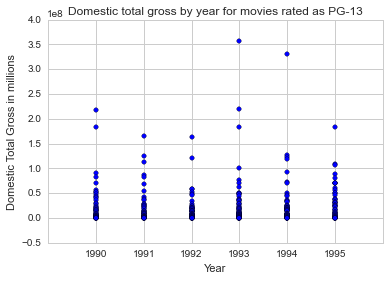

In [126]:
plot_2vars_years(dataPG13, 'PG-13')

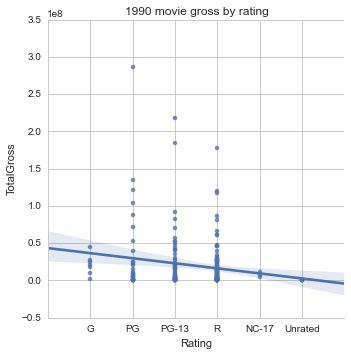

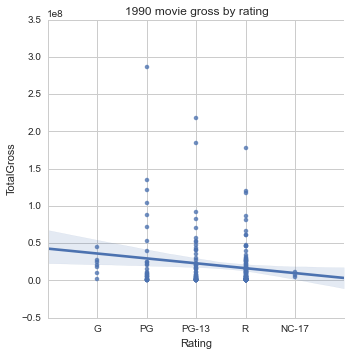

In [125]:
dataPG13 = by_rating('PG-13', 1990, 1995) 

Unresponsive. Trying Again...


In [80]:
dataUnrated = by_rating('Unrated', 1990, 1995)

In [82]:
dataUnrated.head()

,Year,Movie Title,Studio,MPAARating,TotalGross,TGTheaters,Opening,OTheaters,Open,Close
0,1990,The 3rd Animation Celebration,EXPe,Unrated,1289551,N/A,N/A,N/A,12/21,-
1,1990,The Icicle Thief,Aries,Unrated,1231622,22,20809,1,8/24,-
2,1990,C'est La Vie,Gold.,Unrated,805472,28,18749,2,11/2,-
3,1990,The 22nd Tournee of Animation,EXPe,Unrated,768304,N/A,N/A,N/A,3/30,-
4,1990,Henry: Portrait of a Serial Killer,Grey,Unrated,609939,8,N/A,N/A,1/5,-


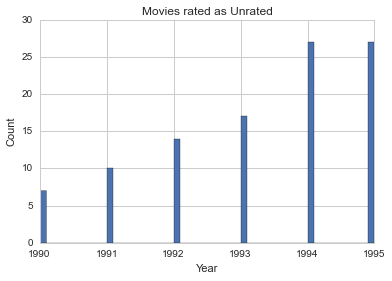

In [120]:
plot_hist_years(dataUnrated, 'Unrated')

In [179]:
# Summary linear model without Unrated category for a year
def summary_lm_unrated(data):
    rating_float = to_float(data['MPAARating'].values)
    labels = ['G','PG','PG-13','R','NC-17','Unrated']
    whereUnrated = np.where(data['MPAARating'].values == 'Unrated')
    firstUnrated = whereUnrated[0][0]
    df = data.loc[:firstUnrated-1,'Studio':'OTheaters']
    df.drop('MPAARating', axis=1, inplace=True)
    df['Rating'] = rating_float[:firstUnrated]
    
    y, X = dmatrices('TotalGross ~ OTheaters', data=df, return_type='dataframe')
#     y, X = dmatrices('TotalGross ~ Rating', data=df, return_type='dataframe')
#     y, X = dmatrices('TotalGross ~ Studio + TGTheaters+ Opening + OTheaters + Rating', data=df, return_type='dataframe')
    model = sm.OLS(y, X)
    results = model.fit()
    return results.summary(), y, X

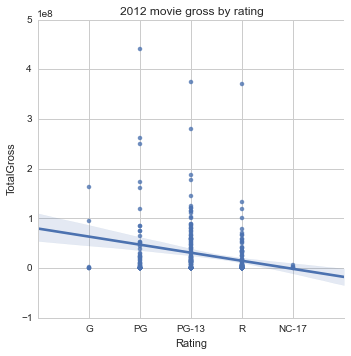

In [158]:
plot_lm_without_unrated(data, 2012)

In [180]:
summ, y, X = summary_lm_unrated(data)

In [181]:
summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TotalGross   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     42.04
Date:                Thu, 16 Jul 2015   Prob (F-statistic):           9.66e-94
Time:                        19:14:43   Log-Likelihood:                -6291.0
No. Observations:                 364   AIC:                         1.296e+04
Df Residuals:                     174   BIC:                         1.370e+04
Df Model:                         189                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            2.275e+05   1.71e+06      0.133      0.894     -3.15e+06   3.6e+06
OTheaters[T.2.0]     1.212e+06   2.94e+06      0.412      0.681     -4.59e+06  7.02e+06
OTheaters[T.3.0]     5.032e+06   3.45e+06      1.458      0.147     -1.78e+06  1.18e+07
OTheaters[T.4.0]     4.233e+06    2.9e+06      1.461      0.146     -1.49e+06  9.95e+06
OTheaters[T.5.0]     1.198e+06   3.09e+06      0.388      0.699      -4.9e+06   7.3e+06
OTheaters[T.6.0]     4.414e+06   3.55e+06      1.243      0.215     -2.59e+06  1.14e+07
OTheaters[T.7.0]     3.659e+06   4.11e+06      0.890      0.375     -4.46e+06  1.18e+07
OTheaters[T.8.0]     2.164e+07   4.57e+06      4.734      0.000      1.26e+07  3.07e+07
OTheaters[T.9.0]     5.915e+06   4.89e+06      1.210      0.228     -3.73e+06  1.56e+07
OTheaters[T.10.0]    3.884e+04    5.3e+06      0.007      0.994     -1.04e+07  1.05e+07
OTheaters[T.11.0]    1.385e+05   1.13e+07      0.012      0.990     -2.23e+07  2.25e+07
OTheaters[T.12]     -2.235e+05   1.13e+07     -0.020      0.984     -2.26e+07  2.22e+07
OTheaters[T.13.0]   -5.423e+04   1.13e+07     -0.005      0.996     -2.25e+07  2.23e+07
OTheaters[T.14.0]    1.272e+05   8.12e+06      0.016      0.988     -1.59e+07  1.61e+07
OTheaters[T.15.0]    1.082e+07   1.13e+07      0.954      0.342     -1.16e+07  3.32e+07
OTheaters[T.16.0]     3.35e+06   5.86e+06      0.571      0.569     -8.22e+06  1.49e+07
OTheaters[T.17.0]   -8443.2907   8.12e+06     -0.001      0.999      -1.6e+07   1.6e+07
OTheaters[T.18.0]    8.808e+05   1.13e+07      0.078      0.938     -2.15e+07  2.33e+07
OTheaters[T.20.0]    4.761e+06    6.7e+06      0.711      0.478     -8.46e+06   1.8e+07
OTheaters[T.22.0]    1.069e+05   5.86e+06      0.018      0.985     -1.15e+07  1.17e+07
OTheaters[T.23.0]    1.877e+06   1.13e+07      0.165      0.869     -2.05e+07  2.43e+07
OTheaters[T.26.0]    1.566e+06   8.12e+06      0.193      0.847     -1.45e+07  1.76e+07
OTheaters[T.29.0]    8.835e+05   1.13e+07      0.078      0.938     -2.15e+07  2.33e+07
OTheaters[T.31]     -2.123e+05   1.13e+07     -0.019      0.985     -2.26e+07  2.22e+07
OTheaters[T.32.0]     2.76e+06   8.12e+06      0.340      0.734     -1.33e+07  1.88e+07
OTheaters[T.35.0]    2.367e+05   1.13e+07      0.021      0.983     -2.22e+07  2.26e+07
OTheaters[T.38]      7.774e+04   1.13e+07      0.007      0.995     -2.23e+07  2.25e+07
OTheaters[T.40.0]    1.024e+08   1.13e+07      9.022      0.000         8e+07  1.25e+08
OTheaters[T.41.0]    1.131e+07   1.13e+07      0.997      0.320     -1.11e+07  3.37e+07
OTheaters[T.42.0]    6.722e+04   1.13e+07      0.006      0.995     -2.23e+07  2.25e+07
OTheaters[T.47]      1.161e+07    6.7e+06      1.733      0.085     -1.61e+06  2.48e+07
OTheaters[T.53]     -1.472e+05   1.13e+07     -0.013      0.990     -2.25e+07  2.23e+07
OTh